                        Hotel Booking Cancellation Prediction

In this project we'll try to use XGBoost  model for reservation cancellation prediction

First let's import all the necessary packages.

In [89]:
import numpy as np
from sklearn.metrics import RocCurveDisplay
from scikitplot.metrics import plot_roc_curve
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import DMatrix
from xgboost import Booster
from sklearn.metrics import accuracy_score
from sklearn import metrics
from pandas.api.types import is_numeric_dtype


The dataset was retrieved here: https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand

 In any kind of data science project, it's critical to examine the data to ensure we understand the format, how it's stored, what types of values it contains, and so on.  Now, let us begin by reviewing our data.

In [69]:
df = pd.read_csv(r"C:\Users\agata\Downloads\archive (7)\hotel_bookings.csv")

In [70]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [71]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
hotel,119390,2,City Hotel,79330,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_canceled,119390.0,NaN,NaN,NaN,0.370416,0.482918,0.0,0.0,0.0,1.0,1.0
lead_time,119390.0,NaN,NaN,NaN,104.011416,106.863097,0.0,18.0,69.0,160.0,737.0
arrival_date_year,119390.0,NaN,NaN,NaN,2016.156554,0.707476,2015.0,2016.0,2016.0,2017.0,2017.0
arrival_date_month,119390,12,August,13877,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arrival_date_week_number,119390.0,NaN,NaN,NaN,27.165173,13.605138,1.0,16.0,28.0,38.0,53.0
arrival_date_day_of_month,119390.0,NaN,NaN,NaN,15.798241,8.780829,1.0,8.0,16.0,23.0,31.0
stays_in_weekend_nights,119390.0,NaN,NaN,NaN,0.927599,0.998613,0.0,0.0,1.0,2.0,19.0
stays_in_week_nights,119390.0,NaN,NaN,NaN,2.500302,1.908286,0.0,1.0,2.0,3.0,50.0
adults,119390.0,NaN,NaN,NaN,1.856403,0.579261,0.0,2.0,2.0,2.0,55.0


As seen below, there's not many null values. Only company seems to be a problem so we'll drop this column. Agent also has some null values but we'll replace them with -1 later when we turn it into categorical variable.

In [72]:
df.isnull().sum().sort_index()/len(df)

adr                               0.000000
adults                            0.000000
agent                             0.136862
arrival_date_day_of_month         0.000000
arrival_date_month                0.000000
arrival_date_week_number          0.000000
arrival_date_year                 0.000000
assigned_room_type                0.000000
babies                            0.000000
booking_changes                   0.000000
children                          0.000034
company                           0.943069
country                           0.004087
customer_type                     0.000000
days_in_waiting_list              0.000000
deposit_type                      0.000000
distribution_channel              0.000000
hotel                             0.000000
is_canceled                       0.000000
is_repeated_guest                 0.000000
lead_time                         0.000000
market_segment                    0.000000
meal                              0.000000
previous_bo

In [73]:
df = df.drop("company",axis=1)

In [74]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,3,No Deposit,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,4,No Deposit,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,No Deposit,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,No Deposit,304.0,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [76]:
df_raw = df.copy()

Let's fix the date time columns to numerical values and drop reservation_status_date.

In [77]:
df_raw['arrival_date_month'] = pd.to_datetime(df_raw['arrival_date_month'],format="%B")
df_raw['reservation_status_date'] = pd.to_datetime(df_raw['reservation_status_date'])
df_raw['Res_Year'] = df_raw['reservation_status_date'].dt.year
df_raw['Res_Month'] = df_raw['reservation_status_date'].dt.month
df_raw['Res_Date'] = df_raw['reservation_status_date'].dt.day
df_raw['arrival_date_month'] = df_raw['arrival_date_month'].dt.month
df_raw = df_raw.drop('reservation_status_date',axis=1)


Now let's change the dtype of all object variables to categorical ones where they are in fact categorical. For example, agent variable has numbers in it that represent each agent. We need to let the program know that it's not a continous numerical variable but a categorical instead.

In [78]:
categorical = []
for col in df_raw.columns[:]:
    if df_raw[col].dtype == 'object' : 
        categorical.append(col)
    elif len(df_raw[col].unique()) == 2:
        categorical.append(col)

        

for col in categorical: 
    df_raw[col] = df_raw[col].astype("category").cat.as_ordered()
    df_raw[col] = df_raw[col].cat.codes

In [79]:
df_raw['agent'] = df_raw['agent'].astype("category").cat.as_ordered()
df_raw['agent'] = df_raw['agent'].cat.codes

Let's verify that we got all of them right

In [80]:
df_raw.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
hotel,119390.0,0.335539,0.472181,0.00,0.00,0.000,1.0,1.0
is_canceled,119390.0,0.370416,0.482918,0.00,0.00,0.000,1.0,1.0
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
arrival_date_year,119390.0,2016.156554,0.707476,2015.00,2016.00,2016.000,2017.0,2017.0
arrival_date_month,119390.0,6.552483,3.090619,1.00,4.00,7.000,9.0,12.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0


We can plot a heatmap to verify the correlation between the variables. We'll drop the Res_Year,day and month variables as they are highly correlated with arrival date.

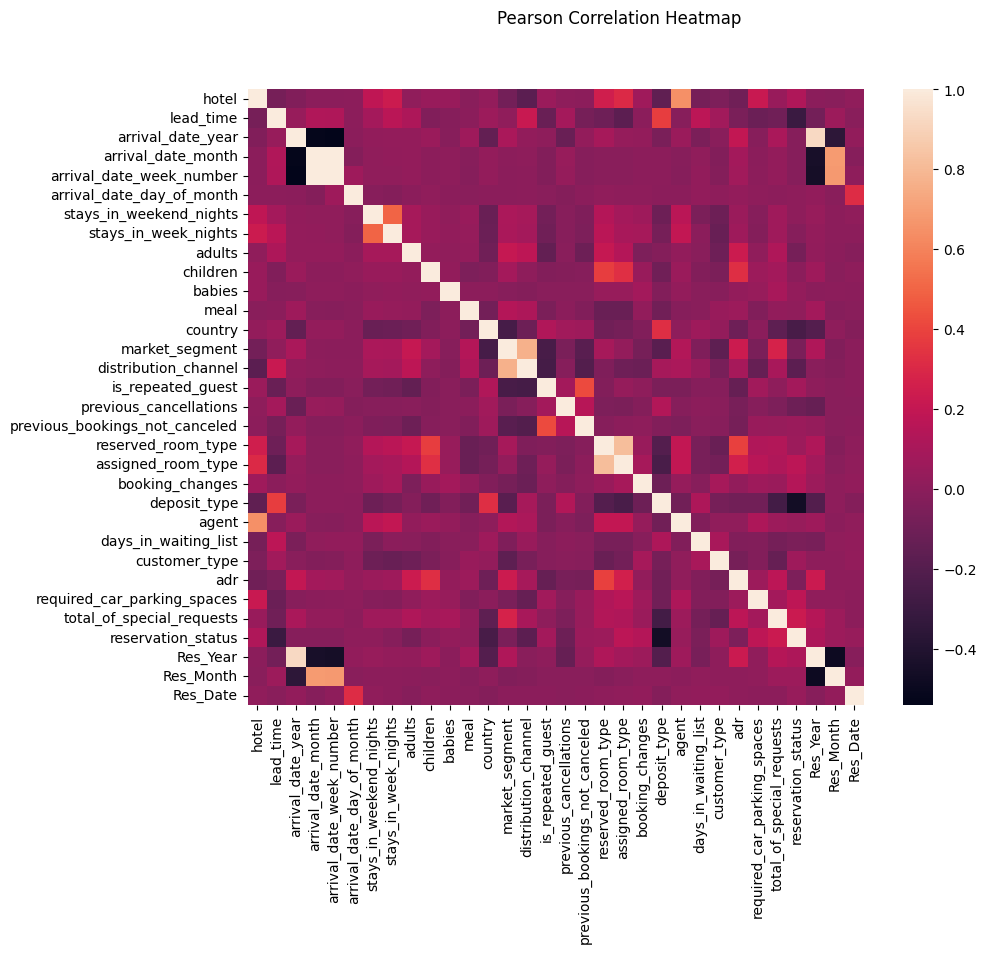

In [81]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_raw.drop('is_canceled', axis=1).corr(), square=True)
plt.suptitle('Pearson Correlation Heatmap')
plt.show()

Let's standardize our numerical columns to transform our data with a mean of 0 and a standard deviation of 1.

In [82]:
means, stds = {}, {}
for name,col in df_raw.items():
    if is_numeric_dtype(col) and col.dtype not in ['bool', 'object'] and name not in categorical and name!="agent":
        means[name], stds[name] = col.mean(), col.std()
        df_raw[name] = (col-means[name])/stds[name] 

In [83]:
df_raw.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
hotel,119390.0,3.355390e-01,0.472181,0.000000,0.000000,0.000000,1.000000,1.000000
is_canceled,119390.0,3.704163e-01,0.482918,0.000000,0.000000,0.000000,1.000000,1.000000
lead_time,119390.0,3.618477e-17,1.000000,-0.973315,-0.804875,-0.327629,0.523928,5.923360
arrival_date_year,119390.0,-8.429909e-14,1.000000,-1.634761,-0.221285,-0.221285,1.192190,1.192190
arrival_date_month,119390.0,8.379631e-17,1.000000,-1.796561,-0.825881,0.144798,0.791918,1.762597
arrival_date_week_number,119390.0,-1.847328e-16,1.000000,-1.923183,-0.820659,0.061361,0.796378,1.898902
arrival_date_day_of_month,119390.0,6.094277e-17,1.000000,-1.685290,-0.888098,0.022977,0.820168,1.731244
stays_in_weekend_nights,119390.0,-1.225997e-17,1.000000,-0.928887,-0.928887,0.072502,1.073890,18.097494
stays_in_week_nights,119390.0,4.427873e-17,1.000000,-1.310234,-0.786204,-0.262173,0.261857,24.891294
adults,119390.0,-5.522939e-17,1.000000,-3.204779,0.247896,0.247896,0.247896,91.743785


In [84]:
df_raw2 = df_raw.copy()

It's time to split our model into train, test and validation sets. We're also dropping before mentioned columns.

In [85]:
train, test = train_test_split(df_raw,test_size=0.2, random_state=12)
key = test['is_canceled']
y_test = test['is_canceled']
X_test = test.drop(['is_canceled','reservation_status','Res_Year',"Res_Month","Res_Date"],axis=1)
X, y = train.drop(['is_canceled','reservation_status','Res_Year',"Res_Month","Res_Date"], axis = 1), train['is_canceled']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=12)

First let's try xgboost.train method to train our model. Most hyper-parameters can be fine-tuned, such as max_depth (maximum tree depth), etc. The result is not bad with 89.8% accuracy.



In [97]:
# Creating DMatrices
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Parameter dictionary
params = {'learning_rate': 0.08,
    'max_depth': 11, 'objective':'binary:logistic',
          'n_estimators':100, 'booster':'gbtree'} 

# Train the model with train data sets
xgb_clf = xgb.train(params,dtrain,1000, watchlist, early_stopping_rounds=100, verbose_eval=50)

preds = xgb_clf.predict(dtest) # Predictions returns as probabilities
y_pred = [round(value) for value in preds]
y_pred = np.array(y_pred).astype(int) # Predictions returns as classes
y_true = y_test # True values

print("Accuracy: ", np.round(accuracy_score(y_true, y_pred), 3))

[15:46:13] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	train-logloss:0.64872	valid-logloss:0.64894


c:\Users\agata\Desktop\Warehouse Club_Agata\.venv\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[50]	train-logloss:0.26069	valid-logloss:0.28179
[100]	train-logloss:0.21639	valid-logloss:0.25995
[150]	train-logloss:0.18762	valid-logloss:0.25140
[200]	train-logloss:0.16564	valid-logloss:0.24616
[250]	train-logloss:0.14930	valid-logloss:0.24363
[300]	train-logloss:0.13434	valid-logloss:0.24162
[350]	train-logloss:0.12339	valid-logloss:0.24099
[400]	train-logloss:0.11228	valid-logloss:0.24067
[450]	train-logloss:0.10025	valid-logloss:0.24141
[495]	train-logloss:0.09154	valid-logloss:0.24193
Accuracy:  0.898


Let's pull a classification report. As we can see the precision for is_cancelled = 0 is 91% and for is_cancelled=1 88%.

In [98]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92     14926
           1       0.88      0.84      0.86      8952

    accuracy                           0.90     23878
   macro avg       0.89      0.89      0.89     23878
weighted avg       0.90      0.90      0.90     23878



Now let's find and plot the most important features in our model.

In [99]:
def get_xgb_imp(xgb, feat_names):
    imp_vals = xgb.get_fscore()
    feats_imp = pd.DataFrame(imp_vals,index=np.arange(2)).T
    feats_imp.iloc[:,0]= feats_imp.index    
    feats_imp.columns=['feature','importance']
    feats_imp.sort_values('importance',inplace=True,ascending=False)
    feats_imp.reset_index(drop=True,inplace=True)
    return feats_imp
    



In [100]:
feat_names = X_train.columns

In [101]:
feature_importance_df = get_xgb_imp(xgb_clf, feat_names)

In [102]:
feature_importance_df

,feature,importance
0,lead_time,20314.0
1,adr,19782.0
2,arrival_date_day_of_month,14050.0
3,arrival_date_week_number,10453.0
4,country,8911.0
5,stays_in_week_nights,6208.0
6,agent,6197.0
7,stays_in_weekend_nights,3865.0
8,arrival_date_month,3072.0
9,total_of_special_requests,2989.0


As we can see below, the most important features are lead_time and adr (average daily rate)

<Axes: >

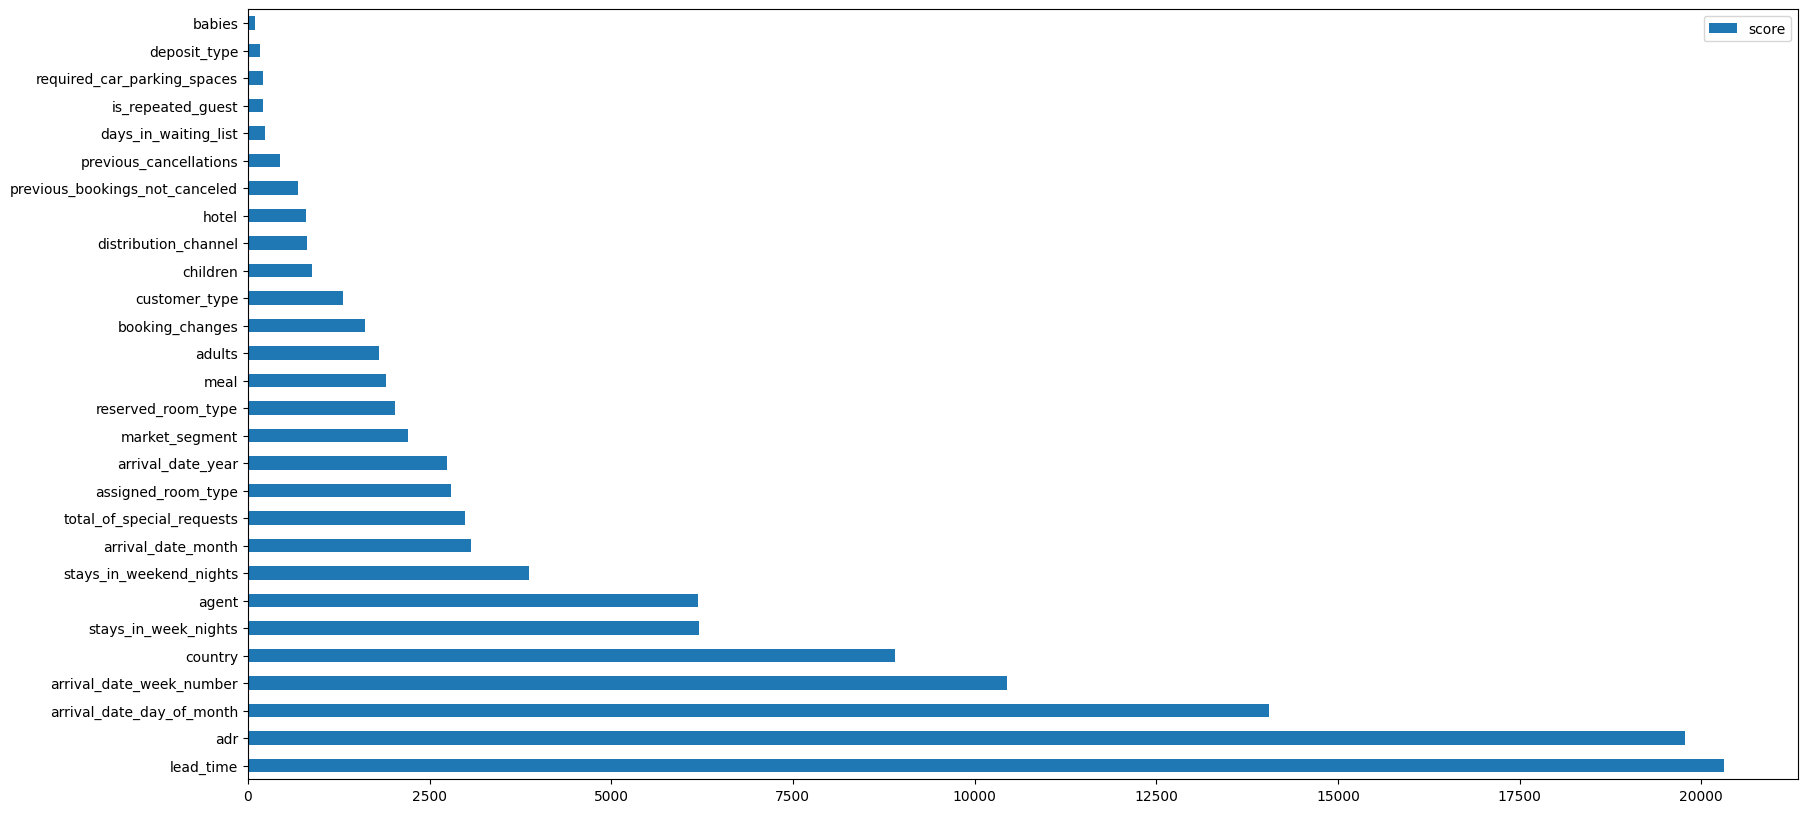

In [103]:
feature_important = xgb_clf.get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.nlargest(28, columns="score").plot(kind='barh', figsize = (20,10)) 